# Initial WSP Data Exploration

Looking at World Stock Price dataset.

In [16]:
import pandas as pd
import numpy as np
import zipfile
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
from seaborn import set_style
set_style("whitegrid")


Some notes:

Use seasonal average model for weekends minus daylight savings weekend to create model
See how well the average predicts daylight savings weekends (null hypothesis is that there is no difference in regular weekends and daylight savings weekends)

Try seasonal average model plus linear model to account for monthly changes plus changes over the years

Use Time Series analysis

Use sklearn with rest of dataset as features and open/close as predictor

Look into using logistic regression for binary type data

In [17]:
#Reads in DST dates
dates = pd.read_csv('DaylightSavingsTimeChangeDates_1971-2024.csv')

#Unzips file
zf = zipfile.ZipFile('historical_stock_prices.csv.zip') 

#Reads in historical stock dataset
metadata = pd.read_csv('historical_stocks.csv')
stock_data = pd.read_csv(zf.open('historical_stock_prices.csv'))

In [18]:
#Set numpy Datetime as index

stock_data['Date'] = pd.to_datetime(stock_data.date, utc=True).apply(lambda x: x.date())
stock_data.drop('date', inplace=True, axis=1)
stock_data.set_index('Date', inplace=True)
stock_data.index = stock_data.index.astype('datetime64[ns]')

In [19]:
#Create arrays of numpy Datetimes corresponding to DST dates

dst_dates_spring = pd.to_datetime(dates.Date+" "+dates.Year.astype(str))
dst_dates_fall = pd.to_datetime(dates['Date.1']+" "+dates.Year.astype(str))
dst_mon_spring = dst_dates_spring+pd.DateOffset(1)
dst_fri_spring = dst_dates_spring+pd.DateOffset(-2)
dst_mon_fall = dst_dates_fall+pd.DateOffset(1)
dst_fri_fall = dst_dates_fall+pd.DateOffset(-2)

In [20]:
#Create boolean columns to denote DST dates, DST fall dates, DST spring dates, Mondays, and Fridays

stock_data['IS_MON'] = stock_data.index.day_of_week==0
stock_data['IS_FRI'] = stock_data.index.day_of_week==4

stock_data['IS_DST'] = stock_data.index.isin(pd.concat([dst_mon_spring, dst_fri_spring, dst_mon_fall, dst_fri_fall]))
stock_data['IS_FALL'] = stock_data.index.isin(pd.concat([dst_mon_fall, dst_fri_fall]))
stock_data['IS_SPRING'] = stock_data.index.isin(pd.concat([dst_mon_spring, dst_fri_spring]))

In [21]:
#Create arrays of tickers separated by sectors (only considering top 4 sectors)

sectors = metadata.sector.unique()

fin_ticks = metadata[metadata.sector == 'FINANCE'].ticker
con_ticks = metadata[metadata.sector == 'CONSUMER SERVICES'].ticker
health_ticks = metadata[metadata.sector == 'HEALTH CARE'].ticker
tech_ticks = metadata[metadata.sector == 'TECHNOLOGY'].ticker

In [22]:
#Sets aside Dataframes specific to each sector of interest

finance = stock_data.loc[stock_data.ticker.isin(fin_ticks.values)]
conservices = stock_data.loc[stock_data.ticker.isin(con_ticks.values)]
healthcare = stock_data.loc[stock_data.ticker.isin(health_ticks.values)]
tech = stock_data.loc[stock_data.ticker.isin(tech_ticks.values)]

In [23]:
#Some market values to track

def daily_return(df, date): #takes dataframe and datetime64[ns]
    assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index"
    close_price = df.loc[date, 'close']
    open_price = df.loc[date, 'open']
    return close_price-open_price

def daily_percent_return(df, date): #takes dataframe and datetime64[ns]
    assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index"
    close_price = df.loc[date, 'close']
    open_price = df.loc[date, 'open']
    return (close_price-open_price)/open_price

def weekend_effect(df): #df is DataFrame for one ticker, with IS_FRI and IS_MON columns
    #assert type(date) == 'datetime64', "date must be datetime64[ns] object"
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index" 
    fri_close = df.loc[df.IS_FRI].close
    mon_open = df.loc[fri_close.index+pd.DateOffset(3)].open
    return fri_close.to_numpy() - mon_open.to_numpy(), (fri_close.to_numpy() - mon_open.to_numpy())/fri_close.to_numpy(), fri_close.index+pd.DateOffset(2) #returns (price difference, percent difference)

def hl_variability(df):
    assert df.index.inferred_type == 'datetime64', "df must have a datetime64[ns] index" 
    dates = df.loc[df.IS_FRI].low.index
    fri_hl = df.loc[df.IS_FRI].high - df.loc[df.IS_FRI].low
    mon_hl = df.loc[dates+pd.DateOffset(3)].high - df.loc[dates+pd.DateOffset(3)].low
    return mon_hl.values, fri_hl.values, dates+pd.DateOffset(2) #returns (price difference, percent difference)
    

In [24]:
#Data preprocessing for descriptive statistics (may not be applicable to time dependent processing)

dataset = pd.DataFrame()

for tk in fin_ticks:
    #Select a single stock from full dataset
    tk_set = finance.loc[finance.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
finance = dataset

In [25]:
#Same treatment for consumer services, health care, and finance
#Data preprocessing for descriptive statistics (may not be applicable to time dependent processing)

dataset = pd.DataFrame()

for tk in con_ticks:
    #Select a single stock from full dataset
    tk_set = conservices.loc[conservices.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
conservices = dataset

dataset = pd.DataFrame()

for tk in health_ticks:
    #Select a single stock from full dataset
    tk_set = healthcare.loc[healthcare.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
healthcare = dataset

dataset = pd.DataFrame()

for tk in tech_ticks:
    #Select a single stock from full dataset
    tk_set = tech.loc[tech.ticker == tk]
    
    #For all Fridays in the subset, find the date of the next Monday
    mon_offset = tk_set.loc[tk_set['IS_FRI']].index+pd.DateOffset(3)
    
    #Create subsubset of subset that only includes Mondays with a corresponding Friday
    mondays = tk_set.loc[mon_offset.unique()[mon_offset.unique().isin(tk_set.index)].strftime('%Y-%m-%d')]
    
    #Create subsubset of subset that only includes the Fridays that correspond to the above Mondays
    fridays = tk_set.loc[(mondays.index.unique()+pd.DateOffset(-3))]
    
    #Alter subset to include all Tues-Thurs, and only those Mondays and Fridays which come in pairs
    tk_set = tk_set[((tk_set.IS_MON==False) & (tk_set.IS_FRI==False)) | (tk_set.index.isin(mondays.index)) | (tk_set.index.isin(fridays.index))]
    
    #Eliminate repeat data (data was taken twice for some stocks on certain days)
    tk_set = tk_set.loc[~tk_set.index.duplicated()]
    
    dataset = pd.concat([dataset, tk_set]).sort_index(ascending=False)
    
tech = dataset

In [26]:
#wk = []
i=0
wt = pd.DataFrame()
cs = pd.DataFrame()
hc = pd.DataFrame()
tc = pd.DataFrame()

for tk in fin_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(finance.loc[finance.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(finance.loc[finance.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    wt = pd.concat([wt, tmp])
    i+=1

for tk in con_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(conservices.loc[conservices.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(conservices.loc[conservices.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    cs = pd.concat([cs, tmp])
    i+=1

for tk in health_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(healthcare.loc[healthcare.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(healthcare.loc[healthcare.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    hc = pd.concat([hc, tmp])
    i+=1

for tk in tech_ticks:
    #print(tk)
    #wk.append(weekend_effect(finance.loc[finance.ticker == tk]))
    price_change, percent, date = weekend_effect(tech.loc[tech.ticker == tk])
    m_hl, f_hl, d_hl = hl_variability(tech.loc[tech.ticker == tk])
    tmp = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl, "Ticker":np.full(percent.shape, tk)})
    #df['col'] = pd.Series('hello', index=df.index, dtype='category')
    tc = pd.concat([tc, tmp])
    i+=1

In [28]:
#Adds IS_DST columns into weekend data

wt['IS_DST'] = wt.Date.isin(pd.concat([dst_dates_spring, dst_dates_fall]))
cs['IS_DST'] = cs.Date.isin(pd.concat([dst_dates_spring, dst_dates_fall]))
hc['IS_DST'] = hc.Date.isin(pd.concat([dst_dates_spring, dst_dates_fall]))
tc['IS_DST'] = tc.Date.isin(pd.concat([dst_dates_spring, dst_dates_fall]))

In [29]:
#Adds IS_FALL and IS_SPRING bools into weekend data

wt['IS_FALL'] = wt.Date.isin(dst_dates_fall)
wt['IS_SPRING'] = wt.Date.isin(dst_dates_spring)

cs['IS_FALL'] = cs.Date.isin(dst_dates_fall)
cs['IS_SPRING'] = cs.Date.isin(dst_dates_spring)

hc['IS_FALL'] = hc.Date.isin(dst_dates_fall)
hc['IS_SPRING'] = hc.Date.isin(dst_dates_spring)

tc['IS_FALL'] = tc.Date.isin(dst_dates_fall)
tc['IS_SPRING'] = tc.Date.isin(dst_dates_spring)

In [30]:
#Check with Wells Fargo data

fN = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_FALL == True)].Percent_Change.shape[0]
wfc_fdst_mean = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_FALL == True)].Percent_Change.mean()
wfc_fdst_std = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_FALL == True)].Percent_Change.std()
wfc_fdst_meanstd = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_FALL == True)].Percent_Change.std()/np.sqrt(fN)
print("Fall DST mean is "+str(wfc_fdst_mean)+"+/-"+str(wfc_fdst_meanstd))

sN = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_SPRING == True)].Percent_Change.shape[0]
wfc_sdst_mean = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_SPRING == True)].Percent_Change.mean()
wfc_sdst_std = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_SPRING == True)].Percent_Change.std()
wfc_sdst_meanstd = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_SPRING == True)].Percent_Change.std()/np.sqrt(sN)
print("Spring DST mean is "+str(wfc_sdst_mean)+"+/-"+str(wfc_sdst_meanstd))

nN = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == False)].Percent_Change.shape[0]
wfc_reg_mean = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == False)].Percent_Change.mean()
wfc_reg_std = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == False)].Percent_Change.std()
wfc_reg_meanstd = wt.loc[(wt.Ticker == 'WFC')&(wt.IS_DST == False)].Percent_Change.std()/np.sqrt(nN)
print("Regular mean is "+str(wfc_reg_mean)+"+/-"+str(wfc_reg_meanstd))

Fall DST mean is 0.0024387879483590276+/-0.0012870524375240364
Spring DST mean is 0.0011017058018877777+/-0.001152712771485811
Regular mean is 0.0002571740587318255+/-0.00022911970515549987


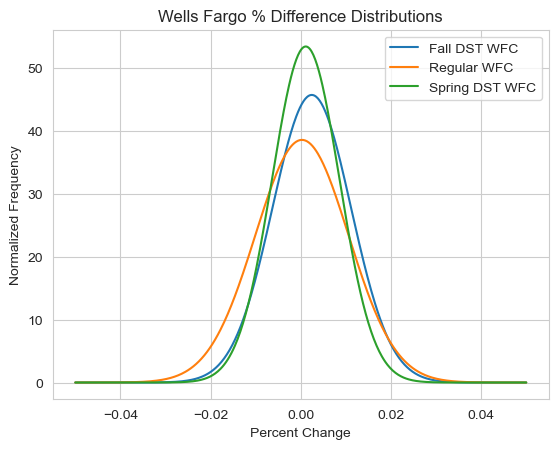

In [31]:
#Distribution plot

# define your distributions
d1 = stats.norm(wfc_fdst_mean, wfc_fdst_std)
d2 = stats.norm(wfc_reg_mean, wfc_reg_std)
d3 = stats.norm(wfc_sdst_mean, wfc_sdst_std)

# where to evaluate the densities
x = np.linspace(-0.05, 0.05, 501)
# calculate density and apply mixture weights
c1 = d1.pdf(x)
c2 = d2.pdf(x)
c3 = d3.pdf(x)

# plot everything
plt.plot(x, c1, label='Fall DST WFC')
plt.plot(x, c2, label='Regular WFC')
plt.plot(x, c3, label='Spring DST WFC')
plt.xlabel("Percent Change")
plt.ylabel("Normalized Frequency")
plt.title("Wells Fargo % Difference Distributions")
plt.legend()

In [32]:
#Gaussian defined for fitting purposes

def gaussian(x, A, x0, sigma): 
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [33]:
#Gaussian fit test with Wells Fargo data

test_data = wt.loc[wt.Ticker == 'WFC']

reg_set = test_data.loc[~test_data.IS_DST].Percent_Change.values
r_bin_width = 2*stats.iqr(reg_set)*(len(reg_set))**(-1/3)
reg_wkend, x_vals = np.histogram(reg_set, bins = int((np.amax(reg_set)-np.amin(reg_set))/r_bin_width), range=(np.amin(reg_set), np.amax(reg_set)), density=True)
x_vals = x_vals[:-1]+(x_vals[1:]-x_vals[:-1])/2
r_bin_err = r_bin_width/2

dst_set = test_data.loc[test_data.IS_FALL].Percent_Change.values
d_bin_width = 2*stats.iqr(dst_set)*(len(dst_set))**(-1/3)
dst_wkend, dst_x_vals = np.histogram(dst_set, bins = int((np.amax(dst_set)-np.amin(dst_set))/d_bin_width), range=(np.amin(dst_set), np.amax(dst_set)), density=True)
dst_x_vals = dst_x_vals[:-1]+(dst_x_vals[1:]-dst_x_vals[:-1])/2
d_bin_err=d_bin_width/2

reg_parms, reg_cov = curve_fit(gaussian, x_vals, reg_wkend, p0=(np.amax(reg_wkend), 0, stats.iqr(reg_set)/2), sigma = r_bin_err+np.sqrt(reg_wkend))
dst_parms, dst_cov = curve_fit(gaussian, dst_x_vals, dst_wkend, p0=(np.amax(dst_wkend), 0, stats.iqr(dst_set)/2), sigma = d_bin_err+np.sqrt(dst_wkend))

/var/folders/jc/xvqs4hmj339bc_532ktftc6w0000gn/T/ipykernel_86623/3243233558.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  test_fig.show()


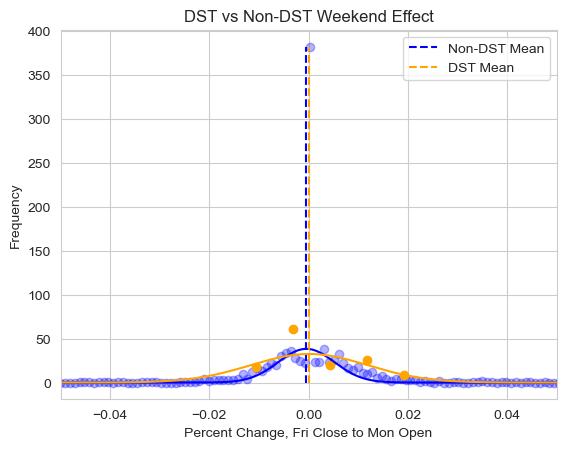

In [34]:
#Plotting Gaussian fit results for WFC

x_fit = np.linspace(x_vals[0], x_vals[-1], 1000)
fit_y = gaussian(x_fit, *reg_parms)
dst_fit_y = gaussian(x_fit, *dst_parms)
#fit_y = stats.norm(loc = reg_parms[1], scale = reg_parms[2])
#dst_fit_y = stats.norm(loc = dst_parms[1], scale = dst_parms[2])

test_fig, test_ax = plt.subplots(nrows=1, ncols=1)#, figsize=(15, 12))
test_ax.plot(x_fit, fit_y, color='blue')
test_ax.scatter(x_vals, reg_wkend, color='blue', alpha=0.3)
test_ax.vlines(reg_parms[1], 0, np.amax(reg_wkend), color='blue', linestyles='dashed', label='Non-DST Mean')
test_ax.plot(x_fit, dst_fit_y, color='orange')
test_ax.scatter(dst_x_vals, dst_wkend, color='orange', alpha=1)
test_ax.vlines(dst_parms[1], 0, np.amax(reg_wkend), color='orange', linestyles='dashed', label='DST Mean')
test_ax.set_xlim(-0.05, 0.05)
test_ax.set_title('DST vs Non-DST Weekend Effect')
test_ax.set_ylabel('Frequency')
test_ax.set_xlabel('Percent Change, Fri Close to Mon Open')
test_ax.legend()
test_fig.show()


In [35]:
#Z score for 2-tailed Gaussian test

z_score = (dst_parms[1] - reg_parms[1])/np.sqrt(reg_parms[2]**2/np.sum(reg_set)+dst_parms[2]**2/np.sum(dst_set))
print('Z-score is '+str(z_score))

cdf = stats.norm.cdf(z_score,0,1)

if cdf>0.5:
    pvalue_2t = 2*(1-cdf)
else :
    pvalue_2t=2*(cdf)

print('p-value is '+str(pvalue_2t))

Z-score is 0.015282149031097652
p-value is 0.9878070838312754


In [36]:
#dist = stats.norm(loc=reg_parms[1], scale=np.sqrt(reg_parms[2]**2+dst_parms[2]**2)) #mean of 0 for zero difference between DST and regular, spread of each Gaussian fit added in quadrature
#z_score = np.sqrt(np.sum(reg_wkend))*(dst_parms[1] - reg_parms[1])/(reg_parms[2])
z_score = (wfc_fdst_mean - wfc_reg_mean)/np.sqrt(wfc_fdst_meanstd**2+wfc_reg_meanstd**2)
print('Z-score is '+str(z_score))

cdf = stats.norm.cdf(z_score,0,1)

if cdf>0.5:
    pvalue_2t = 2*(1-cdf)
else :
    pvalue_2t=2*(cdf)

print('p-value is '+str(pvalue_2t))

Z-score is 1.6688099555562987
p-value is 0.0951550490839217


In [37]:
wfc_tt = stats.ttest_ind(reg_set, dst_set, equal_var=False, nan_policy='omit')
print("T-value is "+str(wfc_tt[0])+" and p value of t-test is "+str(wfc_tt[1]))

T-value is -1.668809955556299 and p value of t-test is 0.10168000225137255


In [38]:
#Fitting Gaussian to all data

'''
significance_array=pd.DataFrame()
empty=[]

for tk in fin_ticks:
    print(tk)
    
    tk_data = wt.loc[wt.Ticker == tk]
    
    #histogram for non-DST weekends
    reg_set = tk_data.loc[~tk_data.IS_DST].Percent_Change.values
    if len(reg_set)==0:
        print("reg_set for "+str(tk)+" is empty")
        empty.append(tk)
        continue
    r_bin_width = 2*stats.iqr(reg_set)*(len(reg_set))**(-1/3) #Optimal bin width via Freedman-Diaconis rule
    if r_bin_width <=0:
        print("bin error for "+str(tk))
        empty.append(tk)
        continue
    reg_wkend, x_vals = np.histogram(reg_set, bins = int((np.amax(reg_set)-np.amin(reg_set))/r_bin_width), range=(np.amin(reg_set), np.amax(reg_set)), density=True)
    x_vals = x_vals[:-1]+(x_vals[1:]-x_vals[:-1])/2 #Middle values of bins
    if ~np.all(np.isfinite(reg_wkend)) and ~np.all(np.isfinite(reg_x_vals)):
        print("histogram for "+str(tk)+" has nans/infs")
        empty.append(tk)
        continue
    if len(x_vals)<3:
        print("Not enough data to fit for "+str(tk))
        empty.append(tk)
        continue
    r_bin_err = r_bin_width/2 #X error set to half bin width
    
    #histogram for DST weekends
    dst_set = tk_data.loc[tk_data.IS_DST].Percent_Change.values
    if len(dst_set)==0:
        print("dst_set for "+str(tk)+" is empty")
        empty.append(tk)
        continue
    d_bin_width = 2*stats.iqr(dst_set)*(len(dst_set))**(-1/3) #Optimal bin width via Freedman-Diaconis rule
    if d_bin_width <=0:
        print("bin error for "+str(tk))
        empty.append(tk)
        continue
    dst_wkend, dst_x_vals = np.histogram(dst_set, bins = int((np.amax(dst_set)-np.amin(dst_set))/d_bin_width), range=(np.amin(dst_set), np.amax(dst_set)), density=True)
    dst_x_vals = dst_x_vals[:-1]+(dst_x_vals[1:]-dst_x_vals[:-1])/2 #Middle values of bins
    if ~np.all(np.isfinite(dst_wkend)) and ~np.all(np.isfinite(dst_x_vals)):
        print("histogram for "+str(tk)+" has nans/infs")
        empty.append(tk)
        continue
    if len(dst_x_vals)<3:
        print("Not enough data to fit for "+str(tk))
        empty.append(tk)
        continue
    d_bin_err=d_bin_width/2 #X error set to half bin width
    
    #non-DST Gaussian fit, error set to bin_err+sqrt(N)
    reg_parms, reg_cov = curve_fit(gaussian, x_vals, reg_wkend, p0=(np.amax(reg_wkend), 0, stats.iqr(reg_set)/2), sigma = r_bin_err+np.sqrt(reg_wkend))
    
    #DST Gaussian fit, error set to bin_err+sqrt(N)
    dst_parms, dst_cov = curve_fit(gaussian, dst_x_vals, dst_wkend, p0=(np.amax(dst_wkend), 0, stats.iqr(dst_set)/2), sigma = d_bin_err+np.sqrt(dst_wkend))
    
    z_score = (dst_parms[1] - reg_parms[1])/np.sqrt(reg_parms[2]**2+dst_parms[2]**2)
    if z_score<0:
        p_val = stats.norm(loc=0, scale=1).cdf(z_score)
    else:
        p_val = 1-stats.norm(loc=0, scale=1).cdf(z_score)
    
    significance_array = pd.concat([significance_array, pd.DataFrame([{"Ticker":tk, "p_value":p_val, "z_score":z_score}])])
    
    '''

'\nsignificance_array=pd.DataFrame()\nempty=[]\n\nfor tk in fin_ticks:\n    print(tk)\n    \n    tk_data = wt.loc[wt.Ticker == tk]\n    \n    #histogram for non-DST weekends\n    reg_set = tk_data.loc[~tk_data.IS_DST].Percent_Change.values\n    if len(reg_set)==0:\n        print("reg_set for "+str(tk)+" is empty")\n        empty.append(tk)\n        continue\n    r_bin_width = 2*stats.iqr(reg_set)*(len(reg_set))**(-1/3) #Optimal bin width via Freedman-Diaconis rule\n    if r_bin_width <=0:\n        print("bin error for "+str(tk))\n        empty.append(tk)\n        continue\n    reg_wkend, x_vals = np.histogram(reg_set, bins = int((np.amax(reg_set)-np.amin(reg_set))/r_bin_width), range=(np.amin(reg_set), np.amax(reg_set)), density=True)\n    x_vals = x_vals[:-1]+(x_vals[1:]-x_vals[:-1])/2 #Middle values of bins\n    if ~np.all(np.isfinite(reg_wkend)) and ~np.all(np.isfinite(reg_x_vals)):\n        print("histogram for "+str(tk)+" has nans/infs")\n        empty.append(tk)\n        continue

In [39]:
fin_mean_significance_array=pd.DataFrame()
empty=[]

for tk in fin_ticks:
    #print(tk)
    
    tk_data = wt.loc[wt.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    reg_mean_std = reg_std/np.sqrt(len(reg_set))
    
    #histogram for fall DST weekends
    fdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_FALL)]
    fdst_mean = fdst_set.Percent_Change.mean()
    fdst_std = fdst_set.Percent_Change.std()
    fdst_mean_std = fdst_std/np.sqrt(len(fdst_set))
    
    #histogram for spring DST weekends
    sdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_SPRING)]
    sdst_mean = sdst_set.Percent_Change.mean()
    sdst_std = sdst_set.Percent_Change.std()
    sdst_mean_std = sdst_std/np.sqrt(len(sdst_set))
    
    fz_score = (fdst_mean - reg_mean)/np.sqrt(fdst_mean_std**2+reg_mean_std**2)
    
    if fz_score<0:
        fp_val = 2*stats.norm(loc=0, scale=1).cdf(fz_score)
    else:
        fp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(fz_score))
        
    sz_score = (sdst_mean - reg_mean)/np.sqrt(sdst_std**2+reg_std**2)
    if sz_score<0:
        sp_val = 2*stats.norm(loc=0, scale=1).cdf(sz_score)
    else:
        sp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(sz_score))
    
    f_tval, f_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, fdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    s_tval, s_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, sdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    fin_mean_significance_array = pd.concat([fin_mean_significance_array, pd.DataFrame([{"Ticker":tk, "fall_z_score":fz_score, "spring_z_score":sz_score, "fall_t_statistic":f_tval, "spring_t_statistic":s_tval, "fall_2tailgaussian_pval":fp_val, "spring_2tailgaussian_pval":sp_val, "fall_ttest_pval":f_ttest_pval, "spring_ttest_pval":s_ttest_pval}])])
    
    

/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [52]:
cs_mean_significance_array=pd.DataFrame()
empty=[]

for tk in con_ticks:
    #print(tk)
    
    tk_data = cs.loc[cs.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    
    #histogram for fall DST weekends
    fdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_FALL)]
    fdst_mean = fdst_set.Percent_Change.mean()
    fdst_std = fdst_set.Percent_Change.std()
    
    #histogram for spring DST weekends
    sdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_SPRING)]
    sdst_mean = sdst_set.Percent_Change.mean()
    sdst_std = sdst_set.Percent_Change.std()
    
    fz_score = (fdst_mean - reg_mean)/np.sqrt(fdst_std**2+reg_std**2)
    if fz_score<0:
        fp_val = 2*stats.norm(loc=0, scale=1).cdf(fz_score)
    else:
        fp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(fz_score))
        
    sz_score = (sdst_mean - reg_mean)/np.sqrt(sdst_std**2+reg_std**2)
    if sz_score<0:
        sp_val = 2*stats.norm(loc=0, scale=1).cdf(sz_score)
    else:
        sp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(sz_score))
    
    f_tval, f_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, fdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    s_tval, s_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, sdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    cs_mean_significance_array = pd.concat([cs_mean_significance_array, pd.DataFrame([{"Ticker":tk, "fall_z_score":fz_score, "spring_z_score":sz_score, "fall_t_statistic":f_tval, "spring_t_statistic":s_tval, "fall_2tailgaussian_pval":fp_val, "spring_2tailgaussian_pval":sp_val, "fall_ttest_pval":f_ttest_pval, "spring_ttest_pval":s_ttest_pval}])])

/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [53]:
hc_mean_significance_array=pd.DataFrame()
empty=[]

for tk in health_ticks:
    #print(tk)
    
    tk_data = hc.loc[hc.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    
    #histogram for fall DST weekends
    fdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_FALL)]
    fdst_mean = fdst_set.Percent_Change.mean()
    fdst_std = fdst_set.Percent_Change.std()
    
    #histogram for spring DST weekends
    sdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_SPRING)]
    sdst_mean = sdst_set.Percent_Change.mean()
    sdst_std = sdst_set.Percent_Change.std()
    
    fz_score = (fdst_mean - reg_mean)/np.sqrt(fdst_std**2+reg_std**2)
    if fz_score<0:
        fp_val = 2*stats.norm(loc=0, scale=1).cdf(fz_score)
    else:
        fp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(fz_score))
        
    sz_score = (sdst_mean - reg_mean)/np.sqrt(sdst_std**2+reg_std**2)
    if sz_score<0:
        sp_val = 2*stats.norm(loc=0, scale=1).cdf(sz_score)
    else:
        sp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(sz_score))
    
    f_tval, f_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, fdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    s_tval, s_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, sdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    hc_mean_significance_array = pd.concat([hc_mean_significance_array, pd.DataFrame([{"Ticker":tk, "fall_z_score":fz_score, "spring_z_score":sz_score, "fall_t_statistic":f_tval, "spring_t_statistic":s_tval, "fall_2tailgaussian_pval":fp_val, "spring_2tailgaussian_pval":sp_val, "fall_ttest_pval":f_ttest_pval, "spring_ttest_pval":s_ttest_pval}])])

/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [54]:
tc_mean_significance_array=pd.DataFrame()
empty=[]

for tk in tech_ticks:
    #print(tk)
    
    tk_data = tc.loc[tc.Ticker == tk]
    
    #mean and std for regular weekends
    reg_set = tk_data.loc[~tk_data.IS_DST]
    reg_mean = reg_set.Percent_Change.mean()
    reg_std = reg_set.Percent_Change.std()
    
    #histogram for fall DST weekends
    fdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_FALL)]
    fdst_mean = fdst_set.Percent_Change.mean()
    fdst_std = fdst_set.Percent_Change.std()
    
    #histogram for spring DST weekends
    sdst_set = tk_data.loc[(tk_data.IS_DST) & (tk_data.IS_SPRING)]
    sdst_mean = sdst_set.Percent_Change.mean()
    sdst_std = sdst_set.Percent_Change.std()
    
    fz_score = (fdst_mean - reg_mean)/np.sqrt(fdst_std**2+reg_std**2)
    if fz_score<0:
        fp_val = 2*stats.norm(loc=0, scale=1).cdf(fz_score)
    else:
        fp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(fz_score))
        
    sz_score = (sdst_mean - reg_mean)/np.sqrt(sdst_std**2+reg_std**2)
    if sz_score<0:
        sp_val = 2*stats.norm(loc=0, scale=1).cdf(sz_score)
    else:
        sp_val = 2*(1-stats.norm(loc=0, scale=1).cdf(sz_score))
    
    f_tval, f_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, fdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    s_tval, s_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, sdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
    tc_mean_significance_array = pd.concat([tc_mean_significance_array, pd.DataFrame([{"Ticker":tk, "fall_z_score":fz_score, "spring_z_score":sz_score, "fall_t_statistic":f_tval, "spring_t_statistic":s_tval, "fall_2tailgaussian_pval":fp_val, "spring_2tailgaussian_pval":sp_val, "fall_ttest_pval":f_ttest_pval, "spring_ttest_pval":s_ttest_pval}])])

/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [55]:
fin_mean_significance_array.dropna().sort_values(by = 'fall_ttest_pval')

,Ticker,fall_z_score,spring_z_score,fall_t_statistic,spring_t_statistic,fall_2tailgaussian_pval,spring_2tailgaussian_pval,fall_ttest_pval,spring_ttest_pval
0,SVBI,10.897692,-0.860483,-10.897692,2.939662,0.000000e+00,0.389523,1.073022e-07,0.077616
0,FNWB,-5.518510,0.248156,5.518510,-1.029829,3.418855e-08,0.804014,6.109034e-03,0.367044
0,AHH,-4.384100,-0.343148,4.384100,1.608774,1.164664e-05,0.731487,8.972171e-03,0.172603
0,GJH,3.481707,-0.101272,-3.481707,0.445597,4.982279e-04,0.919334,9.542851e-03,0.668474
0,GZT,-3.680451,0.192559,3.680451,-0.703218,2.328215e-04,0.847305,9.695921e-03,0.507109
...,...,...,...,...,...,...,...,...,...
0,PJH,-0.010556,0.075651,0.010556,-0.291157,9.915780e-01,0.939697,9.920666e-01,0.781816
0,PJC,0.007970,0.206036,-0.007970,-1.815041,9.936411e-01,0.836763,9.937526e-01,0.086871
0,PFS,-0.002619,0.147265,0.002619,-1.424109,9.979104e-01,0.882923,9.979440e-01,0.170424
0,HCI,0.000055,0.089896,-0.000055,-0.426084,9.999561e-01,0.928370,9.999573e-01,0.679473


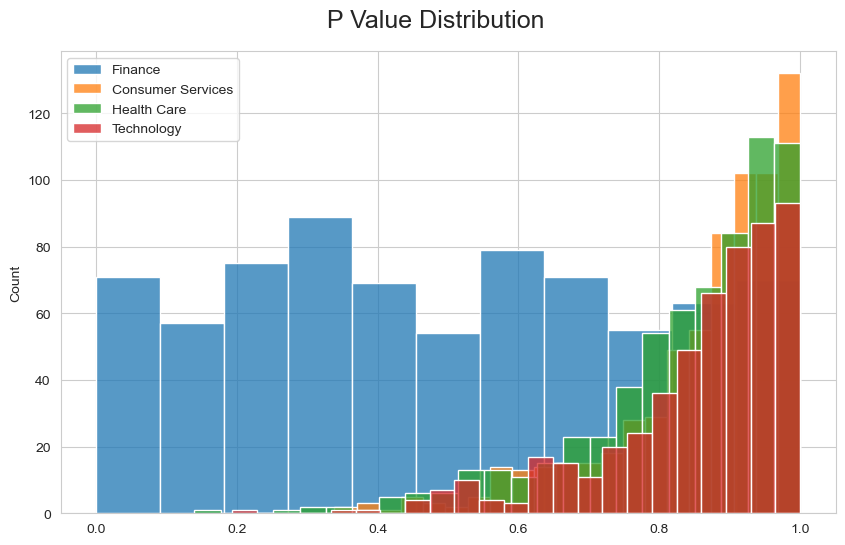

In [60]:
# define subplot grid
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("P Value Distribution", fontsize=18, y=0.95)

# loop through tickers and axes
#for tk, axes in zip(ticker_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
sns.histplot(ax=axes, data = fin_mean_significance_array.dropna(), x="fall_2tailgaussian_pval", label='Finance')#, kde=True)
sns.histplot(ax=axes, data = cs_mean_significance_array.dropna(), x="fall_2tailgaussian_pval", label='Consumer Services')#, kde=True)
sns.histplot(ax=axes, data = hc_mean_significance_array.dropna(), x="fall_2tailgaussian_pval", label='Health Care')#, kde=True)
sns.histplot(ax=axes, data = tc_mean_significance_array.dropna(), x="fall_2tailgaussian_pval", label='Technology')#, kde=True)

axes.legend()

    # chart formatting
#axes.set_title(tk.upper())
    #axes.get_legend().remove()
axes.set_xlabel("")

plt.show()

# T-test (Welch's for unequal variance and sample size)

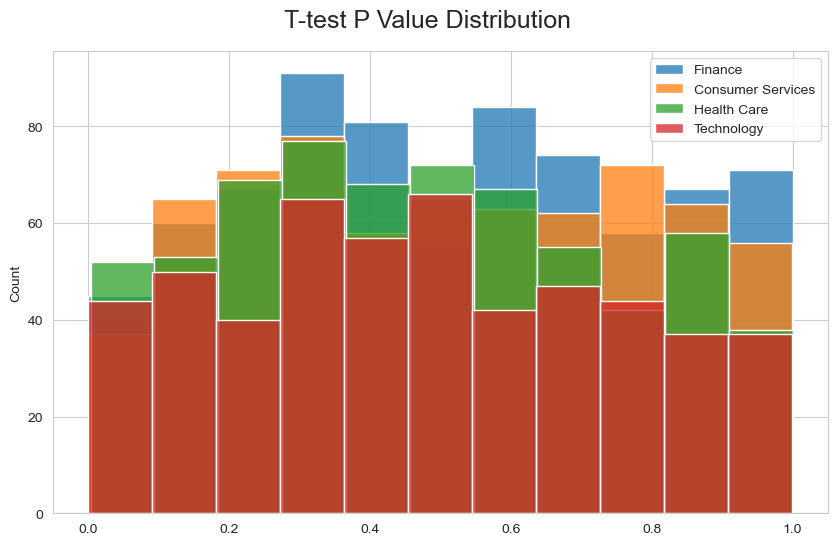

In [61]:
# define subplot grid
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("T-test P Value Distribution", fontsize=18, y=0.95)

# loop through tickers and axes
#for tk, axes in zip(ticker_list, axs.ravel()):
    # filter df for ticker and plot on specified axes
sns.histplot(ax=axes, data = fin_mean_significance_array.dropna(), x="fall_ttest_pval", label='Finance')#, kde=True)
sns.histplot(ax=axes, data = cs_mean_significance_array.dropna(), x="fall_ttest_pval", label='Consumer Services')#, kde=True)
sns.histplot(ax=axes, data = hc_mean_significance_array.dropna(), x="fall_ttest_pval", label='Health Care')#, kde=True)
sns.histplot(ax=axes, data = tc_mean_significance_array.dropna(), x="fall_ttest_pval", label='Technology')#, kde=True)

axes.legend()

    # chart formatting
#axes.set_title(tk.upper())
    #axes.get_legend().remove()
axes.set_xlabel("")

plt.show()

# Assessing Significance of Total Markets

In [62]:
nasdaq_tks = metadata.loc[metadata.exchange == 'NASDAQ'].ticker
nyse_tks = metadata.loc[metadata.exchange == 'NYSE'].ticker

In [63]:
nasdaq_split = finance.loc[finance.ticker.isin(nasdaq_tks.values)]
nyse_split = finance.loc[finance.ticker.isin(nyse_tks.values)]

In [64]:
nasdaq = pd.DataFrame()

for i in nasdaq_split.index.unique():
    current_day = nasdaq_split.loc[nasdaq_split.index == i]
    nasdaq = pd.concat([nasdaq, pd.DataFrame([{"Date":i, "open":current_day.open.sum(), "close":current_day.close.sum(), "low":current_day.low.sum(), "high":current_day.high.sum(), "volume":current_day.volume.sum(), "IS_MON":current_day.IS_MON.iloc[0], "IS_FRI":current_day.IS_FRI.iloc[0], "IS_DST":current_day.IS_DST.iloc[0], "IS_FALL":current_day.IS_FALL.iloc[0], "IS_SPRING":current_day.IS_SPRING.iloc[0]}])])

nasdaq.set_index('Date', inplace=True)
nasdaq.index = nasdaq.index.astype('datetime64[ns]')

nyse = pd.DataFrame()

for i in nyse_split.index.unique():
    current_day = nyse_split.loc[nyse_split.index == i]
    nyse = pd.concat([nyse, pd.DataFrame([{"Date":i, "open":current_day.open.sum(), "close":current_day.close.sum(), "low":current_day.low.sum(), "high":current_day.high.sum(), "volume":current_day.volume.sum(), "IS_MON":current_day.IS_MON.iloc[0], "IS_FRI":current_day.IS_FRI.iloc[0], "IS_DST":current_day.IS_DST.iloc[0], "IS_FALL":current_day.IS_FALL.iloc[0], "IS_SPRING":current_day.IS_SPRING.iloc[0]}])])

nyse.set_index('Date', inplace=True)
nyse.index = nyse.index.astype('datetime64[ns]')

In [65]:
price_change, percent, date = weekend_effect(nasdaq)
m_hl, f_hl, d_hl = hl_variability(nasdaq)
nasdaq_vars = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl})

price_change, percent, date = weekend_effect(nyse)
m_hl, f_hl, d_hl = hl_variability(nyse)
nyse_vars = pd.DataFrame({'Date':date,'Price_Change':price_change, 'Percent_Change':percent, 'Mon_HL_Diff':m_hl, 'Fri_HL_Diff':f_hl})

In [66]:
nasdaq_vars['IS_DST'] = nasdaq_vars.Date.isin(pd.concat([dst_dates_spring, dst_dates_fall]))
nasdaq_vars['IS_FALL'] = nasdaq_vars.Date.isin(dst_dates_fall)
nasdaq_vars['IS_SPRING'] = nasdaq_vars.Date.isin(dst_dates_spring)

nyse_vars['IS_DST'] = nyse_vars.Date.isin(pd.concat([dst_dates_spring, dst_dates_fall]))
nyse_vars['IS_FALL'] = nyse_vars.Date.isin(dst_dates_fall)
nyse_vars['IS_SPRING'] = nyse_vars.Date.isin(dst_dates_spring)

In [67]:
nasdaq_mean_significance_array=pd.DataFrame()
empty=[]

#mean and std for regular weekends
reg_set = nasdaq_vars.loc[~nasdaq_vars.IS_DST]
reg_mean = reg_set.Percent_Change.mean()
reg_std = reg_set.Percent_Change.std()
    
#histogram for fall DST weekends
fdst_set = nasdaq_vars.loc[(nasdaq_vars.IS_DST) & (nasdaq_vars.IS_FALL)]
fdst_mean = fdst_set.Percent_Change.mean()
fdst_std = fdst_set.Percent_Change.std()
    
#histogram for spring DST weekends
sdst_set = nasdaq_vars.loc[(nasdaq_vars.IS_DST) & (nasdaq_vars.IS_SPRING)]
sdst_mean = sdst_set.Percent_Change.mean()
sdst_std = sdst_set.Percent_Change.std()
    
fz_score = (fdst_mean - reg_mean)/np.sqrt(fdst_std**2+reg_std**2)
if fz_score<0:
    fp_val = stats.norm(loc=0, scale=1).cdf(fz_score)
else:
    fp_val = 1-stats.norm(loc=0, scale=1).cdf(fz_score)
        
sz_score = (sdst_mean - reg_mean)/np.sqrt(sdst_std**2+reg_std**2)
if sz_score<0:
    sp_val = stats.norm(loc=0, scale=1).cdf(sz_score)
else:
    sp_val = 1-stats.norm(loc=0, scale=1).cdf(sz_score)
    
f_tval, f_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, fdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
s_tval, s_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, sdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
nasdaq_mean_significance_array = pd.concat([nasdaq_mean_significance_array, pd.DataFrame([{"fall_z_score":fz_score, "spring_z_score":sz_score, "fall_t_statistic":f_tval, "spring_t_statistic":s_tval, "fall_2tailgaussian_pval":fp_val, "spring_2tailgaussian_pval":sp_val, "fall_ttest_pval":f_ttest_pval, "spring_ttest_pval":s_ttest_pval}])])

In [68]:
nyse_mean_significance_array=pd.DataFrame()
empty=[]

#mean and std for regular weekends
reg_set = nyse_vars.loc[~nyse_vars.IS_DST]
reg_mean = reg_set.Percent_Change.mean()
reg_std = reg_set.Percent_Change.std()
    
#histogram for fall DST weekends
fdst_set = nyse_vars.loc[(nyse_vars.IS_DST) & (nyse_vars.IS_FALL)]
fdst_mean = fdst_set.Percent_Change.mean()
fdst_std = fdst_set.Percent_Change.std()
    
#histogram for spring DST weekends
sdst_set = nyse_vars.loc[(nyse_vars.IS_DST) & (nyse_vars.IS_SPRING)]
sdst_mean = sdst_set.Percent_Change.mean()
sdst_std = sdst_set.Percent_Change.std()
    
fz_score = (fdst_mean - reg_mean)/np.sqrt(fdst_std**2+reg_std**2)
if fz_score<0:
    fp_val = stats.norm(loc=0, scale=1).cdf(fz_score)
else:
    fp_val = 1-stats.norm(loc=0, scale=1).cdf(fz_score)
        
sz_score = (sdst_mean - reg_mean)/np.sqrt(sdst_std**2+reg_std**2)
if sz_score<0:
    sp_val = stats.norm(loc=0, scale=1).cdf(sz_score)
else:
    sp_val = 1-stats.norm(loc=0, scale=1).cdf(sz_score)
    
f_tval, f_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, fdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
s_tval, s_ttest_pval = stats.ttest_ind(reg_set.Percent_Change, sdst_set.Percent_Change, equal_var=False, nan_policy='omit')
    
nyse_mean_significance_array = pd.concat([nyse_mean_significance_array, pd.DataFrame([{"fall_z_score":fz_score, "spring_z_score":sz_score, "fall_t_statistic":f_tval, "spring_t_statistic":s_tval, "fall_2tailgaussian_pval":fp_val, "spring_2tailgaussian_pval":sp_val, "fall_ttest_pval":f_ttest_pval, "spring_ttest_pval":s_ttest_pval}])])

In [69]:
nasdaq_mean_significance_array

,fall_z_score,spring_z_score,fall_t_statistic,spring_t_statistic,fall_2tailgaussian_pval,spring_2tailgaussian_pval,fall_ttest_pval,spring_ttest_pval
0,0.133912,0.020178,-1.693395,-0.165179,0.446736,0.491951,0.097593,0.869744


In [70]:
nyse_mean_significance_array

,fall_z_score,spring_z_score,fall_t_statistic,spring_t_statistic,fall_2tailgaussian_pval,spring_2tailgaussian_pval,fall_ttest_pval,spring_ttest_pval
0,0.030394,-0.000373,-1.061689,0.01078,0.487876,0.499851,0.289384,0.991418


The effect size, Cohen's $d$ (which allows for different standard deviations) is:

$$
d = \frac{\mu_{\textrm{reg}} - \mu_{DST}}{s}
$$

where s is the pooled standard deviation, defined as:

$$
s = \sqrt{\frac{(n_1-1)s_1^2+(n_2-1)s_2^2}{n_1+n_2-2}}
$$

and the desired sample size for a power of 0.8 ($\beta = 0.2$) is:

$$
n = \left(\frac{z_\alpha + z_\beta}{d}\right)^2
$$

In [74]:
print(stats.norm.ppf(0.05))
print(stats.norm.ppf(0.2))

-1.6448536269514729
-0.8416212335729142


In [ ]:
d = 
n = ((stats.norm.ppf(0.05)+stats.norm.ppf(0.2))/d**2